In [15]:
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.ticker as mticker
import numpy as np
import cartopy.crs as ccrs
import glob
import os
import xarray as xr

In [16]:
#custom colormap
import pickle

# Load the colormap
with open("fog_colormap.pkl", "rb") as f:
    fog_cmap = pickle.load(f)

In [17]:
djf = ["DEC", "JAN", "FEB"]
mam = ["MAR", "APR", "MAY"] 
jja = ["JUN", "JUL", "AUG"]
son = ["SEP", "OCT", "NOV"]

seasons = [djf, mam, jja, son]

lat_bins = np.arange(-90, 91, 5)
lon_bins = np.arange(0, 361, 5)

lon_grid, lat_grid = np.meshgrid(lon_bins, lat_bins)

In [18]:
path = "data/EECRA/5yr_seasonal/"

files = os.listdir(path)

In [19]:
""" #explore one year
year = "1966"

fig, axs = plt.subplots(2, 2, figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
axs = axs.flatten()

for i, season in enumerate(seasons):
    seasonName = season[0][0]+season[1][0]+season[2][0]
    fn = "counts_"+seasonName+year+".csv"
    
    counts_probOccurance = pd.read_csv(path + fn, sep=',', header=None)
    masked = np.ma.masked_invalid(counts_probOccurance)
    
    ax = axs[i]
    cmap = fog_cmap
    cmap.set_bad('darkgray')

    img = ax.imshow(
        masked,
        extent=[lon_bins[0], lon_bins[-1], lat_bins[0], lat_bins[-1]],
        cmap=cmap,
        origin='lower',
        transform=ccrs.PlateCarree(),
        aspect='auto'
    )
    
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.7, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    ax.set_title(seasonName + " " + year)
    
# Colorbar
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.2, 0.02, 0.6])
fig.colorbar(img, cax=cbar_ax, label='Fog Probability')"""


' #explore one year\nyear = "1966"\n\nfig, axs = plt.subplots(2, 2, figsize=(16, 8), subplot_kw={\'projection\': ccrs.PlateCarree(central_longitude=180)})\naxs = axs.flatten()\n\nfor i, season in enumerate(seasons):\n    seasonName = season[0][0]+season[1][0]+season[2][0]\n    fn = "counts_"+seasonName+year+".csv"\n\n    counts_probOccurance = pd.read_csv(path + fn, sep=\',\', header=None)\n    masked = np.ma.masked_invalid(counts_probOccurance)\n\n    ax = axs[i]\n    cmap = fog_cmap\n    cmap.set_bad(\'darkgray\')\n\n    img = ax.imshow(\n        masked,\n        extent=[lon_bins[0], lon_bins[-1], lat_bins[0], lat_bins[-1]],\n        cmap=cmap,\n        origin=\'lower\',\n        transform=ccrs.PlateCarree(),\n        aspect=\'auto\'\n    )\n\n    ax.coastlines()\n    gl = ax.gridlines(draw_labels=True, linewidth=0.3, color=\'gray\', alpha=0.7, linestyle=\'--\')\n    gl.right_labels = False\n    gl.top_labels = False\n    ax.set_title(seasonName + " " + year)\n\n# Colorbar\nfig.subpl

Seasonal Climatology

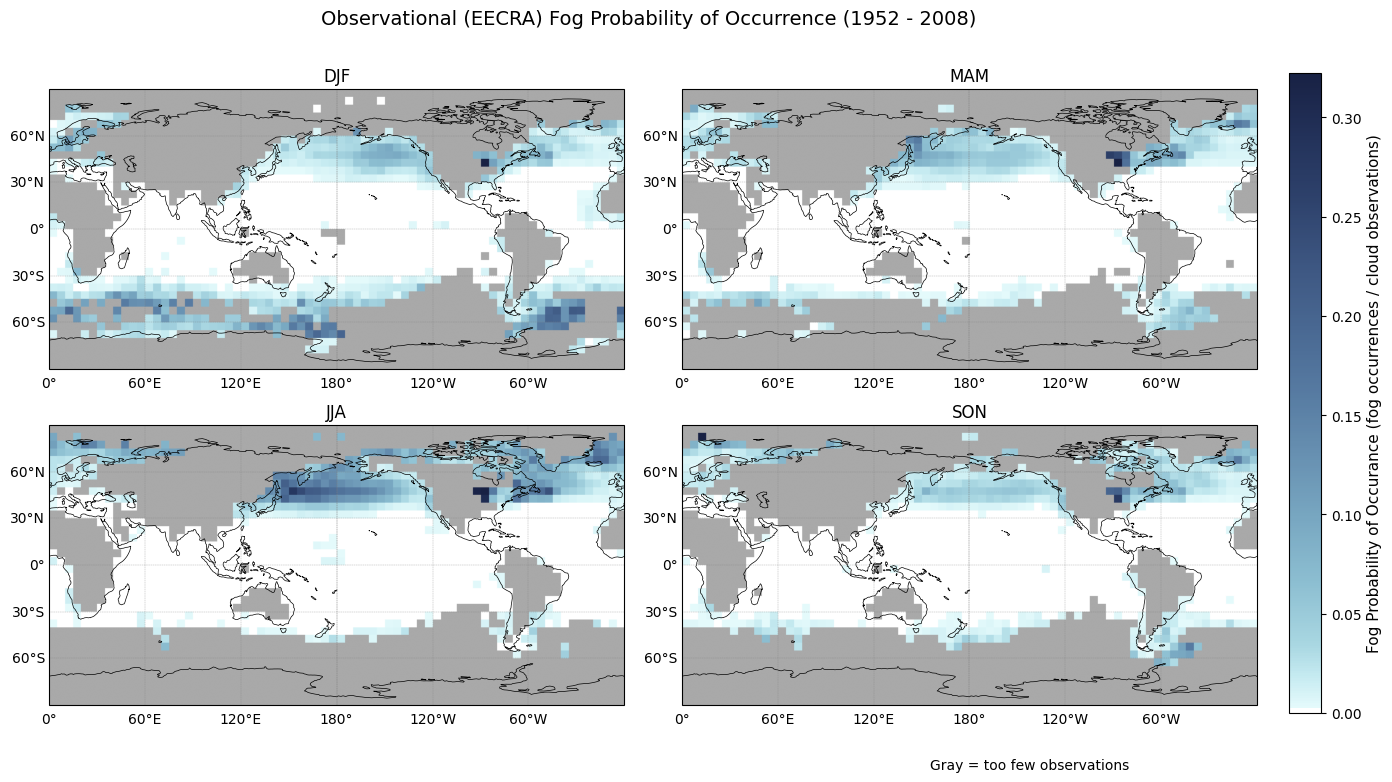

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw={'wspace': 0.1}, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
axs = axs.flatten()

for i, season in enumerate(seasons):
    seasonName = season[0][0]+season[1][0]+season[2][0]
    
    # Get all files that match this season name
    season_files = glob.glob(os.path.join(path, f"*{seasonName}*.csv"))
    
    #get 3d array for all the yrs in season
    data_arrays = []
    for f in season_files:
        df = pd.read_csv(f, sep=',', header=None)
        da = xr.DataArray(df.values, dims=["lat", "lon"])
        data_arrays.append(da)

    stacked = xr.concat(data_arrays, dim="time")
    
    # Mask areas where there is not at least one fog probability value per every 10-15 yrs
    chunks = np.array_split(stacked, 4, axis=0) #chunks of years
    chunk_masks = [(~chunk.isnull()).any(dim='time') for chunk in chunks] #list of masks, areas where there was no observation during chunk
    combined_mask = xr.concat(chunk_masks, dim='chunk').all(dim='chunk') #combine masks

    climatology = stacked.mean(dim='time', skipna=True)
    climatology = climatology.where(combined_mask)
    
    ax = axs[i]
    cmap = fog_cmap
    cmap.set_bad('darkgray')

    img = ax.imshow(
        climatology,
        extent=[lon_bins[0], lon_bins[-1], lat_bins[0], lat_bins[-1]],
        cmap=cmap,
        origin='lower',
        transform=ccrs.PlateCarree(),
        aspect='auto'
    )
    
    ax.coastlines(linewidth=0.5)
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.7, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    ax.set_title(seasonName)
    
# Colorbar
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.1, 0.02, 0.8])
cbar = fig.colorbar(img, cax = cbar_ax)
cbar.set_label("Fog Probability of Occurance (fog occurrences / cloud observations)", fontsize = 11)

fig.suptitle("Observational (EECRA) Fog Probability of Occurrence (1952 - 2008)", fontsize=14)
fig.text(0.8, 0.03, "Gray = too few observations", fontsize=10, ha="right")

plt.savefig("dataViz/EECRASeasonalClimatology")
plt.show()


Fog Trend Map

In [ ]:
def linreg_slope(x, y):
    slope, intercept, r_value, p_value, _ = stats.linregress(time_x, y)
    return slope, intercept, r_value, p_value

dfs = []
for yr in range(1951, 1954, 5): # 2009):
    #get mean of 5yr year, where there have been observations in every season
    seasonalfiles = glob.glob(os.path.join(path, f"*{str(yr)}*.csv"))
    seasonal_das = []
    for f in seasonalfiles:
        df = pd.read_csv(f, sep=',', header=None)
        da = xr.DataArray(df.values, dims=["lat", "lon"])
        
        seasonal_das.append(da)
    stacked = xr.concat(seasonal_das, dim="time") 
    yearDA = stacked.mean("time", skipna=False)
    
    dfs.append(yearDA)

stacked = xr.concat(dfs, dim="time") 
time_x = list (range(len(stacked))) # TODO: *********

# Mask areas where there is not at least one fog probability observation per every 10-15 yrs
chunks = np.array_split(stacked, 4, axis=0) #chunks of years
chunk_masks = [(~chunk.isnull()).any(dim='time') for chunk in chunks] #list of masks, areas where there was no observation during chunk
combined_mask = xr.concat(chunk_masks, dim='chunk').all(dim='chunk') #combine masks

"""results = xr.apply_ufunc(
    linreg_slope,
    time_x,
    yrly_mean_cloud,
    input_core_dims=[['year']],
    output_core_dims=[[], [], [], []],
    vectorize=True,
    output_dtypes=[float, float, float, float],
)"""
    
"""get mean of each year, do not ignor nans
add to dfs[]

stack

chunks (4)
get mask

get mean slope across dfs, ignoring nans

then mask"""

'get mean of each year, do not ignor nans\nadd to dfs[]\n\nstack\n\nchunks (4)\nget mask\n\nget mean slope across dfs, ignoring nans\n\nthen mask'

In [22]:
#set up fig = plt.figure()